# Coins similarity model

In [6]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
from scipy.ndimage.interpolation import rotate

%run ../common/visualisation.ipynb

%matplotlib inline

_dataset_path = "/netforge/datasets/private/roman/coins/images"
_sim_model    = None

## Data

In [7]:
class Dataset:
    def __init__(self, image_shape):
        self.image_shape  = image_shape
        self.train_images = []
        self.test_images  = []

    def load(self, path, data_size):
        files  = os.listdir(path)[:2*data_size]
        file_num = len(files)
        assert file_num >= data_size, "%s %s" % (file_num, data_size)

        h, w, c = self.image_shape
        images = np.zeros([file_num, h, w, c])

        for i,f in enumerate(files):
            f = os.path.join(path, f)
            im = cv2.imread(f)
            if c == 1:
                im = np.max(im, axis=2)
            im = cv2.resize(im, (w,h), interpolation = cv2.INTER_CUBIC).astype('float32')
            im = np.reshape(im, [h,w,c])
            images[i] = im / (im.max()+1e-6)

        idx = np.arange(file_num)
        np.random.shuffle(idx)
        images = images[idx]
        
        self.path         = path
        self.train_images = images[:data_size]
        self.test_images  = images[-data_size:]
        
        return self.train_images, self.test_images, file_num
    
    def get_next_batch(self, bs, aug_func):
        data = self.train_images
        idx1 = np.random.choice(np.arange(len(data)), bs)
        idx2 = np.random.choice(np.arange(len(data)), bs)

        img1 = data[idx1]
        img2 = data[idx2]
        true = np.zeros([bs,2])
        same = np.random.randint(2, size=bs)

        aug = aug_func or (lambda im: im)
        for i in range(bs):
            true[i,same[i]] = 1.
            if same[i]:
                img2[i] = aug(img1[i])
                img1[i] = aug(img1[i])
            else:
                img1[i] = aug(img1[i])
                img2[i] = aug(img2[i])

        return img1, img2, true

### Test data

File num   : 84
Data size  : 42
Train shape: [42, 128, 128, 1]
Test  shape: [42, 128, 128, 1]
Image shape: [128, 128, 1]

Train images:


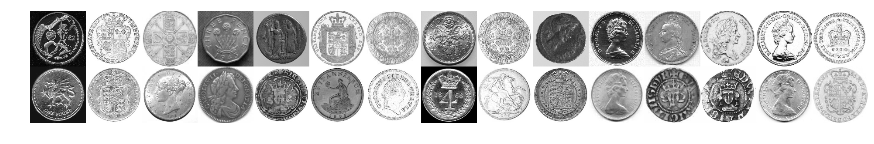

Test images:


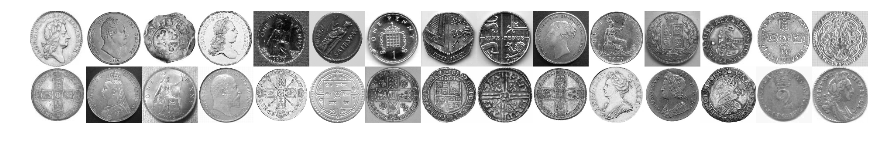

In [8]:
def test_data(data_size):
    image_shape = [128, 128, 1]
    data        = Dataset(image_shape)
    train_images, test_images, file_num = data.load(_dataset_path, data_size)

    print("File num   :", file_num)
    print("Data size  :", data_size)
    print("Train shape:", list(train_images.shape))
    print("Test  shape:", list(test_images.shape))
    print("Image shape:", image_shape)
    print()
    print("Train images:")
    show_images(train_images, image_shape, rows=2, cols=15)
    print("Test images:")
    show_images(test_images, image_shape, rows=2, cols=15)
    
test_data(42)

## Augmentation

In [9]:
class Augmentator:
    _params = {
        'smooth'    : .8,
        'angle'     : 90,
        'brightness': .25,
        'contrast'  : [.5, 1.5],
    }
    
    def __init__(self, cache_size=42):
        self._cache      = dict()
        self._cache_size = cache_size
        
    def augment(self, im, use_cache=True, rate=1):
        shape = im.shape
        w = shape[1]
        h = shape[0]
        if use_cache:
            hc = hash(im.tostring())
            cached = self._cache.get(hc, [])
            if len(cached) >= self._cache_size:
                return np.copy(cached[np.random.randint(self._cache_size)])

        im = np.copy(im)

        # smooth
        p = self._params['smooth']
        k = p*np.random.random(1)**2 * rate
        if k > 0.1:
            kernel = np.ones([5,5],np.float32)/25
            old= np.copy(im)
            im = cv2.filter2D(im,-1,kernel)
            im = np.reshape(im, shape)
            im = k*im + (1-k)*old

        # angle
        p = self._params['angle']
        k = np.random.uniform(-p, p) * rate
        b = np.mean(im[:10,:10])
        im[0,:]   = b
        im[h-1,:] = b
        im[:,0]   = b
        im[:,w-1] = b
        im = rotate(im, k, reshape=False, mode='nearest')

        # brightness
        p = self._params['brightness']
        k = np.random.uniform(1-p, 1+p) * rate
        im = im * k
        im = np.minimum(im,1)
        im = np.maximum(im,0)

        # contrast
        p = self._params['contrast']
        k = rate*np.random.uniform(*p) + (1-rate)
        im = np.power(im, k)

        # bounding
        assert np.all(im<=1)
        assert np.all(im>=0)

        # cache
        if use_cache:
            cached.append(im)
            self._cache[hc] = cached
        return im    

### Test augmentation

Original:


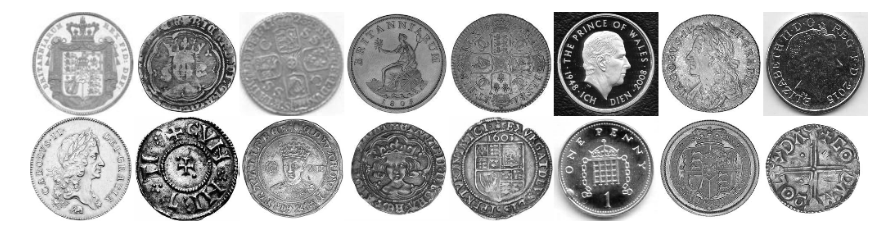

Augmented:


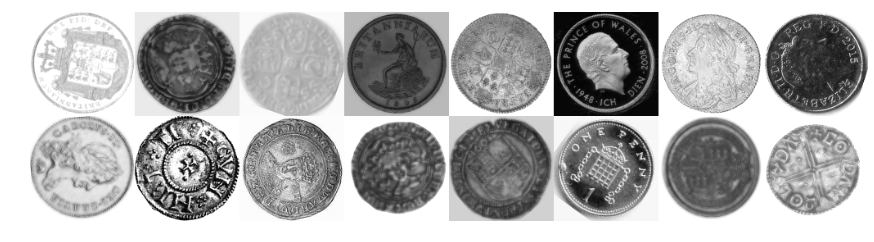

In [10]:
def test_augmentation():
    data_size = 100
    data = Dataset(image_shape=[128, 128, 1])
    aug  = Augmentator()
    data.load(_dataset_path, data_size)

    train_images = data.train_images
    image_shape  = data.image_shape
    augment      = aug.augment

    n = 16
    s = np.random.randint(data_size-n)
    im1 = train_images[s:s+n]
    im2 = np.copy(im1)
    for i in range(n):
        im2[i] = augment(im2[i], use_cache=False, rate=1)
    print("Original:")
    show_images(im1, image_shape, cols=n//2, rows=2)
    print("Augmented:")
    show_images(im2, image_shape, cols=n//2, rows=2)
    
test_augmentation()

### Test batching

data_size: 100
path     : /netforge/datasets/private/roman/coins/images
use_aug  : False
['       0', '       0', '       0', '       1', '       1', '       0', '       1', '       0']


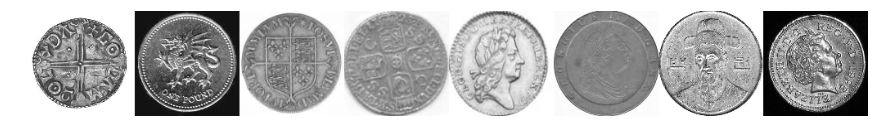

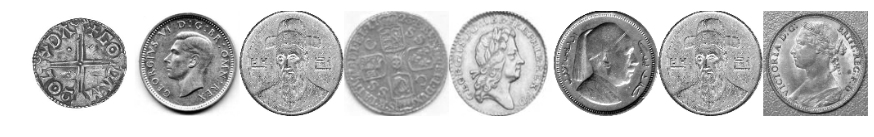

data_size: 100
path     : /netforge/datasets/private/roman/coins/images
use_aug  : True
['       1', '       1', '       1', '       0', '       0', '       0', '       0', '       0']


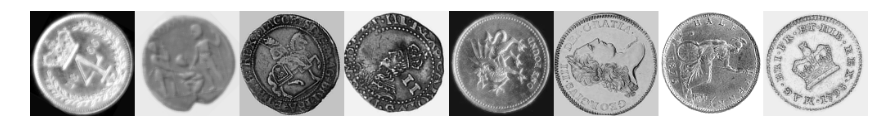

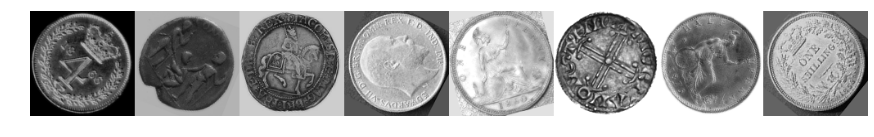

In [11]:
def test_batching(data_size, use_aug):
    data = Dataset(image_shape=[128, 128, 1])
    data.load(_dataset_path, data_size)
    aug = Augmentator()

    train_images   = data.train_images
    image_shape    = data.image_shape
    get_next_batch = data.get_next_batch
    augment        = aug.augment if use_aug else None
    
    n = 8
    im1, im2, t = get_next_batch(n, augment)
    
    print("data_size:", data_size)
    print("path     :", data.path)
    print("use_aug  :", use_aug)
    print(["%8d"%t[i][1] for i in range(len(im1))])
    show_images(im1, image_shape, cols=n, rows=1)
    show_images(im2, image_shape, cols=n, rows=1)
    
test_batching(100, use_aug = False)
test_batching(100, use_aug = True)

## Model

In [12]:
class SimiratityModel:
    
    def __init__(self, image_shape):
        self.data     = Dataset(image_shape)
        self._aug     = Augmentator()
        self._session = None
        self._graph   = None

    def _similarity_nn(self, image1, image2):
        def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs=inputs,
                filters=filters,
                kernel_size=kernel_size,
                padding=padding,
                activation=tf.nn.relu)
            return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.concat([image1, image2], axis=1)
        l = conv2d_maxpool(l, 16)
        l = conv2d_maxpool(l, 32)
        l = conv2d_maxpool(l, 64)
        l = conv2d_maxpool(l, 128)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=2)
        logits     = l
        similarity = tf.nn.softmax(logits)
        return {'logits':logits, 'similarity':similarity}

    def load_data(self, data_path, data_size):
        self.data.load(data_path, data_size)
        self._is_loaded = True

    def build(self):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        with self._graph.as_default(), tf.name_scope('similarity'), tf.device('/gpu:0'):
            # placeholders
            self.image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            self.image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            self.true_pl   = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='true')
            self.lr_pl     = tf.placeholder(dtype=tf.float32, name='lr')
            # network
            self.network   = self._similarity_nn(self.image1_pl, self.image2_pl)
            # operations
            self.logits_op = self.network['logits']
            self.sim_op    = self.network['similarity']
            self.loss_op   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.true_pl, logits=self.logits_op))
            self.train_op  = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
        self._is_built = True

    def train(self, step_num, batch_size, learning_rate = 1e-4, stop_loss=.1, log_every=3, mean_win = 30):
        assert self._is_loaded, "Model data is not loaded"
        assert self._is_built,  "Model is not built"
        
        if self._session:
            self._session.close()
        
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
            
        try:
            losses   = []
            for step in range(step_num):
                img1, img2, true = self.data.get_next_batch(batch_size, self._aug.augment)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.image1_pl: img1,
                    self.image2_pl: img2,
                    self.true_pl  : true,
                    self.lr_pl    : learning_rate
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, mean_win)
                if np.mean(losses[-mean_win:]) < stop_loss:
                    break
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, mean_win)

    def augment(self, images, use_cache=False, rate=1):
        augmented = np.zeros_like(images)
        for i in range(len(images)):
            augmented[i] = self._aug.augment(images[i], use_cache, rate)
        return augmented

    def get_similarity(self, img1, img2):
        return self._session.run(self.sim_op, feed_dict = {
            self.image1_pl: img1,
            self.image2_pl: img2
        })[:,1]



### Test train

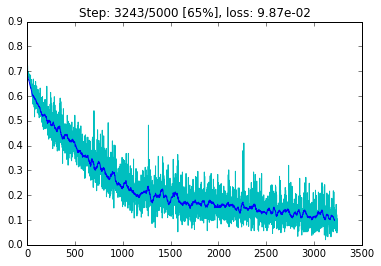

CPU times: user 18min 18s, sys: 5min 12s, total: 23min 31s
Wall time: 18min 44s


In [13]:
%%time
def test_train_model(step_num, data_size, batch_size, stop_loss):
    model = SimiratityModel(image_shape=[128,128,1])
    model.load_data(_dataset_path, data_size)
    model.build()
    model.train(step_num=step_num, batch_size=batch_size, stop_loss=stop_loss)
    return model
    
_sim_model = test_train_model(step_num=5000, data_size=1200, batch_size=100, stop_loss=.1)

### Test similarity

0.92 0.97 0.95 0.99 1.00 0.96 0.94 1.00 0.83 0.97 0.98 1.00 0.99 0.97 0.98 0.90 0.98 0.98 0.97 1.00
==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ====


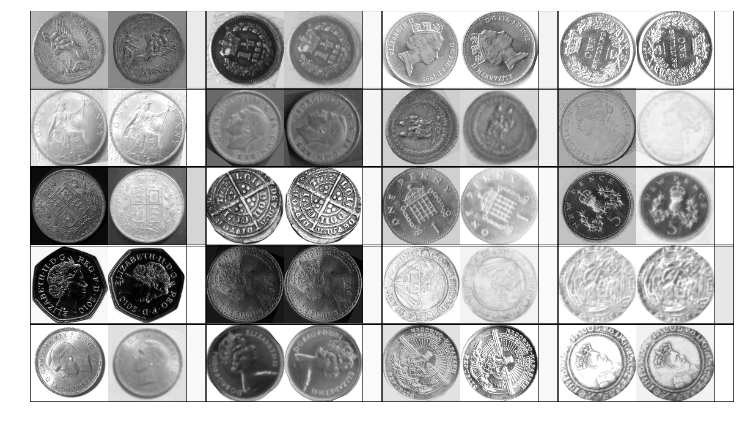

0.00 0.00 0.00 0.00 0.00 0.03 0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.25 0.00
                                                                                                   


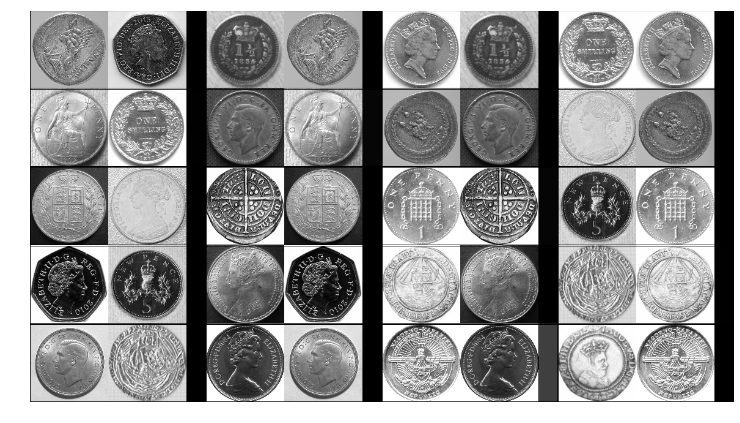

In [14]:
def show_similarity(img1, img2, sim, cols=4):
    num = img1.shape[0]
    h   = img1.shape[1]
    w   = img1.shape[2]
    w3  = 32
    img1 = np.copy(img1.reshape([num*h,w]))
    img2 = np.copy(img2.reshape([num*h,w]))
    img3 = np.ones([num*h, w3])
    for i in range(num):
        s = sim[i]
        assert(0.<=s<=1.)
        img3[i*h:i*h+h] = s
    img1[:,0] = 0
    img3[:,w3-1] = 0
    img3[:,0] = 0
    sheet = np.concatenate([img1, img2, img3], axis=1)
    sheet[np.arange(0,num*h,h)-1,:] = 0
    sheet[np.arange(0,num*h,h)+1,:] = 0
    sheet = np.minimum(sheet, 1)
    print(' '.join(['%.2f'%s for s in sim]))
    print(' '.join(['='*4 if s>.5 else ' '*4 for s in sim]))    
    show_images(images=sheet, image_shape=[h, 2*w+w3], cols=cols, rows=num//cols)
    
def test_similarity(model, num):
    assert model, "Model is not defined"
    images  = model.data.test_images
    shift   = np.random.randint(len(images))
    
    # positive
    im1 = np.roll(images, shift, axis=0)[:num]
    im2 = im1
    im1 = model.augment(im1)
    im2 = model.augment(im2)
    sim = model.get_similarity(im1, im2)
    show_similarity(im1, im2, sim) 
    
    # negative
    im1 = np.roll(images, shift  , axis=0)[:num]
    im2 = np.roll(images, shift+1, axis=0)[:num]
    sim = model.get_similarity(im1, im2)
    show_similarity(im1, im2, sim) 

test_similarity(_sim_model, num=20)

### Test quality

Data size   : 500
Mean pos sim: 94.6%
Mean neg sim: 7.2%


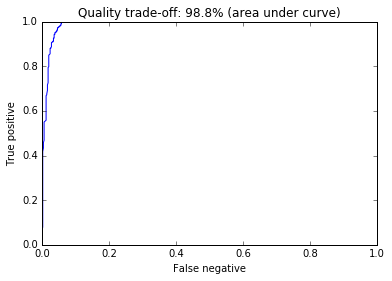

CPU times: user 6.82 s, sys: 352 ms, total: 7.18 s
Wall time: 7.03 s


In [15]:
%%time
def show_quality(pos_sim, neg_sim):
    print("Data size   :", len(pos_sim))
    print("Mean pos sim: %.1f%%" % (np.mean(pos_sim)*100))
    print("Mean neg sim: %.1f%%" % (np.mean(neg_sim)*100))
    n = 1000
    x = np.zeros(n)
    y = np.zeros(n)
    s = 0
    for i in range(n):
        p = i/n
        x[i] = 1 - np.mean(neg_sim < p)
        y[i] = np.mean(pos_sim > p)
        if i>0:
            s += (y[i]+y[i-1])/2 * (x[i-1]-x[i])
    plt.plot(x, y)
    plt.title("Quality trade-off: %.1f%% (area under curve)" % (s*100))
    plt.xlabel("False negative")
    plt.ylabel("True positive")
    plt.show()

def test_quality(model):
    assert model, "Model is not defined"
    images = model.data.test_images
    num    = min(500, len(images))
    shift  = np.random.randint(len(images))
    
    # positive
    im1 = np.roll(images, shift, axis=0)[:num]
    im2 = im1
    im1 = model.augment(im1)
    im2 = model.augment(im2)
    pos = model.get_similarity(im1, im2)
    
    # negative
    im1 = np.roll(images, shift  , axis=0)[:num]
    im2 = np.roll(images, shift+1, axis=0)[:num]
    neg = model.get_similarity(im1, im2)
    
    show_quality(pos_sim = pos, neg_sim = neg)

test_quality(_sim_model)

## [EOF]